In [1]:
import matplotlib.pyplot as plt
from scipy.stats import probplot
import seaborn as sns

In [2]:
import sys
sys.path.append('../scripts/')

In [3]:
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
import time

from numpy_sugar import ddot
from numpy_sugar.linalg import economic_qs

from limix.qc import quantile_gaussianize
from cellregmap import CellRegMap

from settings import DEFAULT_PARAMS, FILTERED_KINSHIP_PATH
from sim_utils import (
    create_variances,
    set_causal_ids,
    sample_clusters,
    sample_endo,
    create_environment_factors,
    # create_kinship_matrix,
    create_kinship_factors,
    simulate_data,
    sample_nb,
    run_cellregmap_fixed,
)

In [4]:
params = DEFAULT_PARAMS

In [5]:
params['model'] = 'cellregmap'

In [6]:
params['threads'] = 1

In [7]:
params

{'n_snps': 50,
 'n_individuals': 50,
 'n_genes': 50,
 'cells_per_individual': 'fixed',
 'n_cells': 100,
 'maf_min': 0.2,
 'maf_max': 0.45,
 'real_genotypes': True,
 'env': 'endo',
 'n_env': 20,
 'n_env_gxe': 20,
 'n_env_tested': 20,
 'offset': 2.5,
 'n_causal_g': 1,
 'n_causal_gxe': 1,
 'n_causal_shared': 1,
 'r0': 0.5,
 'v0': 0.03,
 'likelihood': 'negbin',
 'nb_dispersion': 2,
 'p_dropout': 0.05,
 'normalize': True,
 'dirichlet_alpha': 2,
 'seed': 19350,
 'model': 'cellregmap',
 'threads': 1}

In [8]:
params['n_env'] = 10
params['n_env_gxe'] = 10
params['n_env_tested'] = 10

In [9]:
params['real_genotypes'] = False

In [10]:
params['n_individuals'] = 15
params['n_snps'] = 250
params['n_cells'] = 50
params['v0'] = 0

In [11]:
# ===============================================================================
# Check values
# ===============================================================================
n_causal = params["n_causal_g"] + params["n_causal_gxe"] - params["n_causal_shared"]
if n_causal > params["n_snps"]:
    raise ValueError("Number SNPs with genetic effects has to be < n_snps.")
if params["v0"] > 0:
    if (params["n_causal_g"] == 0) ^ (params["r0"] == 1):
        print(
            "Warning: Only one of n_causal_g, 1-r0 is zero. Simulating no persistent effect."
        )
    if (params["n_causal_gxe"] == 0) ^ (params["r0"] == 0):
        print(
            "Warning: Only one of n_causal_gxe, r0 is zero. Simulating no gxe effect."
        )
if params["n_env_tested"] > params["n_env"]:
    raise ValueError("n_env_tested has to be smaller than n_env")

# ===============================================================================
# Simulate data & run tests in parallel across multiple genes
# ===============================================================================
# initialize random number generator
random = np.random.default_rng(params["seed"])

# (1) set parameters which are fixed for all genes, such as the envrionment
# matrix, population/repeat structure and their respective factorizations:

# set indices of causal SNPs
(g_causals, gxe_causals) = set_causal_ids(
    n_causal_g=params["n_causal_g"],
    n_causal_gxe=params["n_causal_gxe"],
    n_causal_shared=params["n_causal_shared"],
)

# set cells per donor
if params["cells_per_individual"] == "fixed":
    n_cells = params["n_cells"]
elif params["cells_per_individual"] == "variable":
    # n_cells = np.arange(params['n_individuals']) + 1
    # make sure n_cells.sum() equals params['n_cells'] * params['n_individuals']
    n = params["n_individuals"]
    n_cells = np.linspace(1, n, n) * 2 * params["n_cells"] / (n + 1)
    n_cells = n_cells.round().astype(int)
else:
    raise ValueError(
        "Invalid cells_per_individual value: %s" % params["cells_per_individual"]
    )

print("Setting up environment matrix ...")
# create environment matrix and decomposition
if params["env"] == "endo":
    # sample cells for one simulated individual from only one real individual
    respect_individuals = True
    if params["n_individuals"] > 124:
        respect_individuals = False
    E = sample_endo(
        params["n_env"],
        params["n_individuals"],
        n_cells,
        random,
        respect_individuals=respect_individuals,
    )
elif params["env"] == "cluster_uniform":
    E = sample_clusters(params["n_env"], params["n_individuals"], n_cells, random)
elif params["env"] == "cluster_biased":
    E = sample_clusters(
        params["n_env"],
        params["n_individuals"],
        n_cells,
        random,
        params["dirichlet_alpha"],
    )
else:
    raise ValueError("Invalid env value: %s" % params["env"])
env = create_environment_factors(E)

print("Setting up kinship matrix ...")
# create factors of kinship matrix
if params["real_genotypes"]:
    if params["n_individuals"] > 100:
        raise ValueError("n_individuals > 100. Use artificial genotypes.")
    K = pd.read_csv(FILTERED_KINSHIP_PATH, index_col=0)
    donor_ids = K.index[: params["n_individuals"]].tolist()
    K = K.iloc[: params["n_individuals"], : params["n_individuals"]].to_numpy()
else:
    K = np.eye(params["n_individuals"])
    donor_ids = None
Lk = create_kinship_factors(K).Lk
# expand from donors to cells
Lk = Lk[np.repeat(range(params["n_individuals"]), n_cells), :]

# create factors of E + K * E
us = env.U * env.S
Ls = tuple([ddot(us[:, i], Lk) for i in range(us.shape[1])])

# compute QS if using fixed effect model (these models also include E as fixed effects)
QS = None
if params["model"].startswith("cellregmap_fixed"):
    print("Factorizing K * EE ... ")
    QS = economic_qs((Lk @ Lk.T) * (env.E @ env.E.T))

# set variances
v = create_variances(
    r0=params["r0"], v0=params["v0"], include_noise=params["likelihood"] == "gaussian"
)


# (2) simulate data for each gene and run tests:

Setting up environment matrix ...
Setting up kinship matrix ...


In [12]:
def sim_and_test(random: np.random.Generator):
    # simulates data for one gene and computes p-values

    # set ids of environments with GxE effects
    env_gxe_active = random.choice(E.shape[1], params["n_env_gxe"])

    s = simulate_data(
        offset=params["offset"],
        n_individuals=params["n_individuals"],
        n_snps=params["n_snps"],
        n_cells=n_cells,
        env=env,
        env_gxe_active=env_gxe_active,
        Ls=Ls,
        maf_min=params["maf_min"],
        maf_max=params["maf_max"],
        real_genotypes=params["real_genotypes"],
        donor_ids=donor_ids,
        g_causals=g_causals,
        gxe_causals=gxe_causals,
        variances=v,
        random=random,
    )

    # adjust likelihood model
    if params["likelihood"] == "gaussian":
        y = s.y
    elif params["likelihood"] == "negbin":
        mu = np.exp(params["offset"] + s.y_g + s.y_gxe + s.y_k + s.y_e)
        y = sample_nb(mu=mu, phi=params["nb_dispersion"], random=random)
        y = np.log(y + 1)
    elif params["likelihood"] == "zinb":
        mu = np.exp(params["offset"] + s.y_g + s.y_gxe + s.y_k + s.y_e)
        y = sample_nb(mu=mu, phi=params["nb_dispersion"], random=random)
        y *= random.binomial(1, 1 - params["p_dropout"], size=y.size)
        y = np.log(y + 1)
    elif params["likelihood"] == "poisson":
        lam = np.exp(params["offset"] + s.y_g + s.y_gxe + s.y_k + s.y_e)
        y = random.poisson(lam=lam)
        y = np.log(y + 1)
    else:
        raise ValueError("Unknown likelihood %s" % params["likelihood"])

    if params["normalize"] and params["likelihood"] != "gaussian":
        y = quantile_gaussianize(y)

    # set up model & run test
    y = y.reshape(y.shape[0], 1)
    M = np.ones_like(y)

    t_start = time.time()
    if params["model"] == "cellregmap":
        model = CellRegMap(
            y=y, W=M, E=None, E0=env.E[:, : params["n_env_tested"]], E1=env.E, Ls=s.Ls
        )
        pv = model.scan_interaction(s.G)[0]
    elif params["model"] == "cellregmap_assoc":
        model = CellRegMap(
            y=y, W=M, E=None, E0=env.E[:, : params["n_env_tested"]], E1=env.E, Ls=s.Ls
        )
        pv = model.scan_association(s.G)[0]
    elif params["model"] == "structlmm":
        model = CellRegMap(
            y=y, W=M, E=None, E0=env.E[:, : params["n_env_tested"]], E1=env.E
        )
        pv = model.scan_interaction(s.G)[0]
    elif params["model"] == "cellregmap_fixed_single_env":
        pv = run_cellregmap_fixed(
            y=y,
            M=M,
            E0=env.E[:, : params["n_env_tested"]],
            E1=env.E,
            G=s.G,
            QS=QS,
            joint=False,
        )
    elif params["model"] == "cellregmap_fixed_multi_env":
        pv = run_cellregmap_fixed(
            y=y,
            M=M,
            E0=env.E[:, : params["n_env_tested"]],
            E1=env.E,
            G=s.G,
            QS=QS,
            joint=True,
        )
    else:
        raise ValueError("Unknown model %s" % params["model"])
    time_elapsed = time.time() - t_start
    return np.asarray(pv, float), s.snp_ids, time_elapsed, s

In [20]:
def qqplot(x, ax, **plot_kwargs):
    (osm, osr), _ = probplot(x, dist='uniform')
    df = pd.DataFrame({'osm': -np.log10(osm), 'osr': -np.log10(osr)})
    sns.scatterplot(x='osm', y='osr', data=df, ax=ax, edgecolor=None, s=12, **plot_kwargs)
    m = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([0, m], [0, m], c='grey', linestyle=':')
    ax.set(xlabel=r'Expected $-\log_{10} P$', ylabel=r'Observed $-\log_{10} P$')

In [13]:
adw = 1245321

In [14]:
params['model'] = 'cellregmap'

In [15]:
pvals, snp_ids, times, s = sim_and_test(np.random.default_rng(adw))

100%|██████████| 250/250 [09:15<00:00,  2.22s/it]


In [16]:
pvals

array([0.41012967, 0.67737708, 0.54870192, 0.56012368, 0.34827251,
       0.198678  , 0.28850517, 0.30546612, 0.11820375, 0.99402159,
       0.82905391, 0.34611979, 0.69372648, 0.86830655, 0.10330423,
       0.75313833, 0.34496345, 0.6251454 , 0.95904763, 0.34108279,
       0.42356354, 0.33138736, 0.38213647, 0.39675127, 0.70002054,
       0.9322221 , 0.50752225, 0.922691  , 0.2155578 , 0.07505084,
       0.76588254, 0.36676767, 0.30560683, 0.40385769, 0.82870155,
       0.83481511, 0.15734198, 0.63431076, 0.59856218, 0.57355658,
       0.48232816, 0.29240042, 0.06257108, 0.44277517, 0.83171063,
       0.65481881, 0.02716859, 0.07715919, 0.18664515, 0.66291566,
       0.03915296, 0.47245245, 0.31197214, 0.2154648 , 0.01242101,
       0.63126972, 0.1827062 , 0.61965232, 0.51307385, 0.26985156,
       0.36537828, 0.58308665, 0.31282442, 0.4594537 , 0.1449654 ,
       0.13915558, 0.28606622, 0.8308257 , 0.82178155, 0.47002694,
       0.89827215, 0.33216916, 0.32409131, 0.71902344, 0.66650

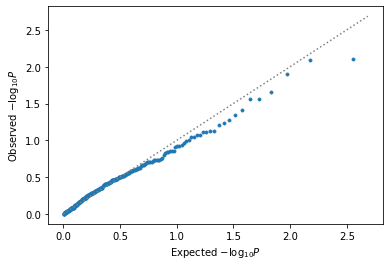

In [22]:
fig, ax = plt.subplots()
qqplot(pvals, ax)

In [23]:
params['model'] = 'cellregmap_fixed_single_env'

In [ ]:
pvals, snp_ids, times, s = sim_and_test(np.random.default_rng(adw))

  4%|▍         | 11/250 [00:01<00:56,  4.24it/s]/omics/groups/OE0540/internal/users/heinent/miniconda3/envs/cellregmap/lib/python3.8/site-packages/glimix_core/lmm/_lmm_scan.py:389: RuntimeWarning: invalid value encountered in sqrt
  se = sqrt(nice_inv(left).diagonal())
 97%|█████████▋| 243/250 [4:42:03<28:31, 244.47s/it]  

In [ ]:
pvals

In [ ]:
daw

In [ ]:
params['model'] = 'cellregmap_fixed_multi_env'

In [ ]:
pvals, snp_ids, times, s = sim_and_test(np.random.default_rng(adw))

In [ ]:
pvals

In [ ]:
params['model'] = 'cellregmap_assoc'

In [ ]:
pvals, snp_ids, times, s = sim_and_test(np.random.default_rng(adw))

In [ ]:
pvals